# Microbatch training

Производится обучение модели с помощью градиентного спуска или его модификаций, при котором градиенты считаются по батчам (например, размера 1024). Для оптимизации работы с памятью GPU предлагается разбивать батчи на микробатчи (например, размера 16), оценивать градиенты для каждого микробатча по отдельности, затем на их основе считать градиент уже для всего батча и делать шаг оптимизации.

In [1]:
import sys
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append('..\..')

from microbatch import load, define_model, train_on_batch

%matplotlib inline

Предлагаемый алгоритм рассмотрим на примере MNIST размера $28 \times 28$. Посмотрим, как будет меняться время выполнения одного шага обучения на батче в зависимости от размера микробатча. Разбиение на микробатчи производится на уровне numpy (см. microbatch.py)

In [2]:
MNIST_SIZE = 10000
N_EPOCHS = 2
BATCH_SIZE = 1024
N_ITER = MNIST_SIZE // BATCH_SIZE

In [3]:
# загрузка данных
images, labels = load(MNIST_SIZE)

# определим tf модель (3 свёрточных слоя, 2 полносвязных)
session, x_ph, y_ph, set_zero, accum_op, train_op, loss = define_model()

# рассмотрим микробатчи размера, кратного BATCH_SIZE (1,2,4,...)
grid = np.arange(1,BATCH_SIZE+1)[(BATCH_SIZE % np.arange(1,BATCH_SIZE+1)) == 0]
times_per_iter = []

for micro_batch_size in grid:
    times = []
    rams = []
    ix = np.arange(len(images))
    for ep in tqdm(range(N_EPOCHS)):
        np.random.shuffle(ix)
        for it in range(N_ITER):
            indices = ix[it * BATCH_SIZE: (it + 1) * BATCH_SIZE]
            batch_x = images[indices]
            batch_y = labels[indices]
            time_it= train_on_batch(session, 
                                    [x_ph, y_ph], 
                                    [batch_x, batch_y], 
                                    micro_batch_size, 
                                    set_zero, 
                                    accum_op, 
                                    train_op)
            times.append(time_it)
    times_per_iter.append(times)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.82it/s]


In [4]:
# Обучение по микробатчам
"""
    session.run(set_zero)
    for x, y in zip(x_splitted, y_splitted):
        session.run(accum_op, feed_dict={x_ph: x, y_ph: y})
    session.run(train_op)
"""

'\n    session.run(set_zero)\n    for x, y in zip(x_splitted, y_splitted):\n        session.run(accum_op, feed_dict={x_ph: x, y_ph: y})\n    session.run(train_op)\n'

In [5]:
time_per_iter = np.mean(np.array(times_per_iter), axis=1)

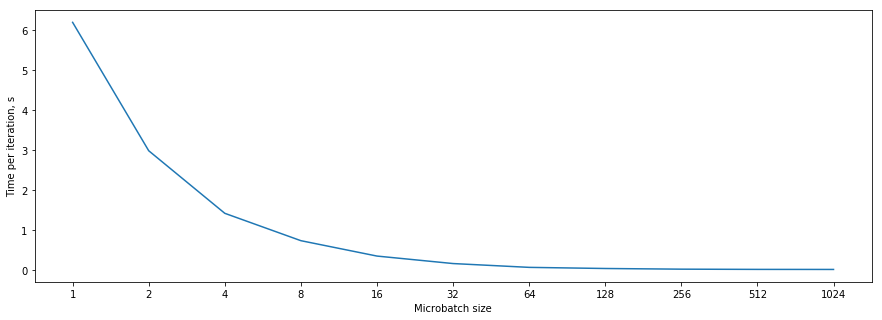

In [6]:
plt.figure(figsize = (15,5))
plt.plot(time_per_iter)
plt.xticks(range(len(grid)), grid)
plt.xlabel('Microbatch size')
plt.ylabel('Time per iteration, s')
plt.show()

Другой подход к реализации алгоритма основан на разбиении батча на микробатчи с помощью tf.split на уровне tensorflow (см. subbatch.py). Оказалось, что при малом разбиении на микробатчи сильно расходуется память, что скорее всего связано с реализацией split в tensorflow.